# Raster Gap Filling

In this tutorial we will fill **no-data** gaps in a series of rasters, using different functions provided by `eumap.gapfiller`.

First, let's import the necessary modules.

In [37]:
import sys

# Add the repository root in the path
# If the eumap isn't instaled you should do it   
sys.path.append('../../')

from eumap import datasets
from eumap.misc import find_files
from eumap import raster
from eumap import gapfiller

datasets.TILES

['10636_switzerland',
 '14576_netherlands',
 '14580_netherlands',
 '15560_poland',
 '16057_ireland',
 '22497_sweden',
 '4582_spain',
 '5606_greece',
 '9326_italy',
 '9529_croatia']

We will use a time-series of LANDSAT raster for Sweden, downloading the raster data from [Zenodo](https://zenodo.org/record/4058447).

In [2]:
tile = datasets.TILES[5]
datasets.get_data(tile+'_rasters.tar.gz')

Now, let's generate a list of file paths sorted by time, starting from the oldest raster.

In [3]:
from pathlib import Path
import os

def get_fn_rasters(tile, band, perc):
    
    data_root = datasets.DATA_ROOT_NAME
    tile_dir = Path(os.getcwd()).joinpath(data_root, tile) # eumap.datasets.get_data() downloads to the current working directory by default
        
    seasons = ['winter', 'spring', 'summer', 'fall']
    
    fn_rasters = []
    for year in range(2000, 2020):
        for season in seasons:
            fn_rasters += find_files(dir_list=[tile_dir], dir_pattern=f'{year}/landsat*{season}*{band}*{perc}*.tif')
    
    return fn_rasters

perc = 'p50'
band = 'nir'
# we will use the 50th percentile of the LANDSAT NIR band provided in the eumap datasets
fn_rasters = get_fn_rasters(tile, band, perc)

print(f'Total number of files: {len(fn_rasters)}')
print(f'- First file: {fn_rasters[0]}')
print(f'- Last file: {fn_rasters[len(fn_rasters)-1]}')

Total number of files: 80
- First file: /home/jupyter/leandro/Code/eumap/demo/python/eumap_data/22497_sweden/2000/landsat_ard_winter_nir_p50.tif
- Last file: /home/jupyter/leandro/Code/eumap/demo/python/eumap_data/22497_sweden/2019/landsat_ard_fall_nir_p50.tif


## Temporal Moving Window Median (TMWM)

This method works in the **temporal domain**, using different combinations of temporal moving window (based in the parameter `time_win_size`) to calculate several median values, prioritizing them in three phases of gap filling attempts. The **phase 1** uses only observations of the same season/month/day in different years, doubling the temporal moving window until find some available median value to fill the gap. If all the values of the same season/month/day are no-data, the **phase 2** applies the same approach considering the average between the two neighborhood season(s)/month(s)/day(s). The **phase 3** tries to fill the gap using a median value calculated with all observations available in different years. If a specific pixel has only no-data value in all the observation (a no-data time-series) the gap will remaining after all TMWM attempts:

![TMWM](https://gitlab.com/geoharmonizer_inea/eumap/-/raw/master/img/tmwm.png?inline=false "Gap filling example for two pixels using TMWM and the time_win_size=4")

In [4]:
tmwm = gapfiller.TMWM(fn_files=fn_rasters, yearly_temporal_resolution=4, time_win_size=4)
data_tmwm = tmwm.run()
fn_rasters_tmwm = tmwm.save_rasters('./gapfilled_tmwm', data_type='uint8')

[22:03:45] Reading 80 raster files using 10 workers
[22:03:49] Data (1000, 1000, 20) organized in time=0
[22:03:49] Data (1000, 1000, 20) organized in time=1
[22:03:49] Data (1000, 1000, 20) organized in time=2
[22:03:49] Data (1000, 1000, 20) organized in time=3
[22:03:50] There are 29925745 gaps in (1000, 1000, 80)
[22:03:50] Calculating 172 gap filling possibilities
[22:03:50] Using cpu engine
[22:04:56] Possibilities calculated
[22:05:02] 100.00% of the gaps filled in 71.68 segs
[22:05:08] Number of files saved in gapfilled_tmwm: 160


You can check that **all the gaps** were filled and *160 raster files* were saved, 80 files with the gapfilled time series data and 80 files containing the size of the **temporal moving window used** to fill the gap.

Let's plot the result for a specific pixels:

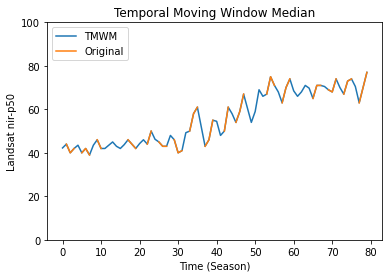

In [5]:
import matplotlib.pyplot as plt

# pixel position in the numpy array
x, y = 50, 50

plt.plot(tmwm.gapfilled_data[x, y, :], label='TMWM')
plt.plot(tmwm.data[x, y, :], label='Original')

plt.title('Temporal Moving Window Median')
plt.ylabel(f'Landsat {band}-{perc}')
plt.xlabel('Time (Season)')
plt.legend(loc="upper left")
plt.ylim([0, 100])
plt.show()

It's possible check the the size of the moving windown used to calculated the median value:
* **Same season**: values between 0 and n_years (ex: ``pixel_value=4`` and ``window_size=4``)
* **Neighborhood seasons**: values between n_years and n_years*2 (ex: ``pixel_value=24`` and ``window_size=4``)
* **All seasons**: values between n_years*2 and n_years*3 (ex: ``pixel_value=44`` and ``window_size=4``)

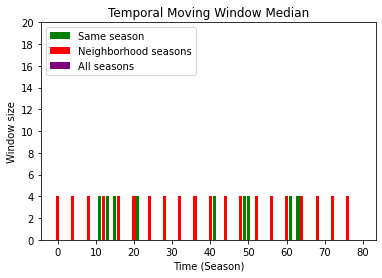

In [6]:
import numpy as np
from matplotlib.ticker import MaxNLocator

def plt_bar(time_flag, tmwm_flag, mask_flag, color, label, rescale_factor):
    masked_tmwm_flag = np.zeros(ts_size)
    masked_tmwm_flag[mask_flag] = tmwm_flag[mask_flag] - rescale_factor
    plt.bar(time_flag, masked_tmwm_flag, color=color, label=label)

tmwm_flag = tmwm.gapfilled_data_flag[x, y, :]

ts_size = len(tmwm_flag)
season_size = 4
n_years = (ts_size / season_size)
time_flag = range(0, ts_size)

same_season_mask = (tmwm_flag < n_years)
plt_bar(time_flag, tmwm_flag, same_season_mask, 'Green', 'Same season', 0)

neib_season_mask = np.logical_and((tmwm_flag >= n_years), (tmwm_flag < n_years*2))
plt_bar(time_flag, tmwm_flag, neib_season_mask, 'Red', 'Neighborhood seasons', n_years)

all_season_mask = (tmwm_flag >= n_years*2)
plt_bar(time_flag, tmwm_flag, all_season_mask, 'Purple', 'All seasons', n_years*2)

ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Temporal Moving Window Median')
plt.ylabel(f'Window size')
plt.xlabel('Time (Season)')
plt.legend(loc="upper left")
plt.ylim([0, 20])
plt.show()

## Temporal Linear Interpolation (TLI)

This method works in the **temporal domain**, using a linear regression ([LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) over the time to interpolate the no-data values:

In [7]:
tli = gapfiller.TLI(fn_files=fn_rasters)
data_tli = tli.run()
fn_rasters_tli = tli.save_rasters('./gapfilled_tli', data_type='uint8')

[22:05:09] Reading 80 raster files using 10 workers
[22:05:13] There are 29925745 gaps in (1000, 1000, 80)
[22:06:20] 100.00% of the gaps filled in 67.18 segs
[22:06:27] Number of files saved in gapfilled_tli: 160


You can check that **all the gaps** were filled and 160 raster files were saved, 80 files with the gapfilled time series data and 80 files containing the `Root Mean Square Error` of the fitted regression.

Let's plot the result for a specific pixels:

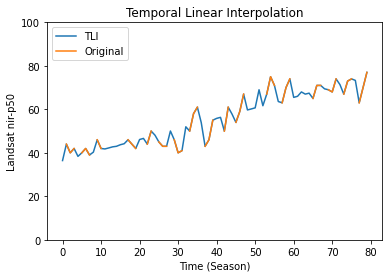

In [8]:
import matplotlib.pyplot as plt

# pixel position in the numpy array
x, y = 50, 50

plt.plot(tli.gapfilled_data[x, y, :], label='TLI')
plt.plot(tli.data[x, y, :], label='Original')

plt.title('Temporal Linear Interpolation')
plt.ylabel(f'Landsat {band}-{perc}')
plt.xlabel('Time (Season)')
plt.legend(loc="upper left")
plt.ylim([0, 100])
plt.show()

It's also possible retrieve the **RMSE** for the fitted regression, which will change in the space:

In [9]:
print(f'RMSE:')
print(f' -Pixels {x-1} {y-1}: {tli.gapfilled_data_flag[x-1, y-1, 0]:.3f}')
print(f' -Pixels {x} {y}: {tli.gapfilled_data_flag[x, y, 0]:.3f}')
print(f' -Pixels {x+1} {y+1}: {tli.gapfilled_data_flag[x+1, y+1, 0]:.3f}')

RMSE:
 -Pixels 49 49: 4.063
 -Pixels 50 50: 5.486
 -Pixels 51 51: 6.593


## Spatial Moving Window Median (SMWM)

This method works in the **spatial domain**, using different spatial moving windows (based in the parameter `space_win_size`) to calculate several median values and fill the no-data values. It's a very limited way to fill the gaps and should be used only when all the observation in the time are no-data (a no-data time-series).

In [10]:
space_win_list = range(5, 21, 5)
print(f'space_win_list = {list(space_win_list)}')
smwm = gapfiller.SMWM(fn_files=fn_rasters,  space_win_list = range(5, 21, 5))
data_smwm = smwm.run()
fn_rasters_smwm = smwm.save_rasters('./gapfilled_smwm', data_type='uint8')

space_win_list = [5, 10, 15, 20]
[22:06:27] Reading 80 raster files using 10 workers
[22:06:31] There are 29925745 gaps in (1000, 1000, 80)
[22:07:12] 8.27% of the gaps filled in 41.09 segs
[22:07:13] Remained gaps: 27451101
[22:07:20] Number of files saved in gapfilled_smwm: 160


You can check that just **8.27%** of the gaps were filled (*not so impressive*) and 160 raster files were saved, 80 files with the gapfilled time series data and 80 files containing the size of the spatial moving window used to fill the gap.

## Gapfilled Raster Data

Now it's time to compare the gapfilled data produced by the three approaches:

Image: /home/jupyter/leandro/Code/eumap/demo/python/eumap_data/22497_sweden/2012/landsat_ard_fall_nir_p50.tif


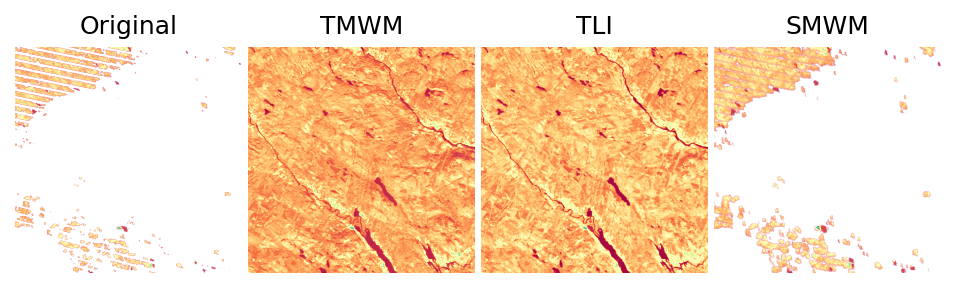

In [11]:
from eumap import plotter

i = 51
img_gaps = fn_rasters[i]
img_gapfilled_tmwm = fn_rasters_tmwm[i*2]
img_gapfilled_tli = fn_rasters_tli[i*2]
img_gapfilled_smwm = fn_rasters_smwm[i*2]

print(f'Image: {img_gaps}')
plotter.plot_rasters(
    img_gaps,
    img_gapfilled_tmwm,
    img_gapfilled_tli,
    img_gapfilled_smwm,
    cmaps='Spectral',
    figsize=8,
    titles=['Original', 'TMWM', 'TLI', 'SMWM'],
)

Let's also look in the rasters containing the metadata information about the gapfilling approach:

Image: /home/jupyter/leandro/Code/eumap/demo/python/eumap_data/22497_sweden/2012/landsat_ard_fall_nir_p50.tif


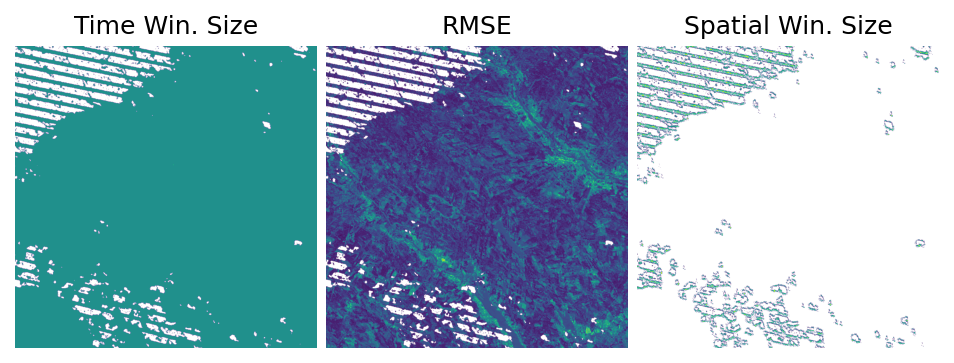

In [12]:
from eumap import plotter

img_gapfilled_tmwm_flag = fn_rasters_tmwm[i*2+1]
img_gapfilled_tli_flag = fn_rasters_tli[i*2+1]
img_gapfilled_smwm_flag = fn_rasters_smwm[i*2+1]

print(f'Image: {img_gaps}')
plotter.plot_rasters(
    img_gapfilled_tmwm_flag,
    img_gapfilled_tli_flag,
    img_gapfilled_smwm_flag,
    cmaps='viridis',
    figsize=8,
    titles=['Time Win. Size', 'RMSE', 'Spatial Win. Size'],
)

This approach enables us to apply spatial/spatiotemporal modeling and mapping on datasets with a high level of cloud and cloud shadow occurrences.

Time to change the variable **tile** and see the result for other region of EU.

## Combined Approach

It's possible combine two or more gapfilling though the properties `gapfilled_data` and `data`. To illustrate that we will use the Switzerland tile

In [13]:
tile = datasets.TILES[0]
datasets.get_data(tile+'_rasters.tar.gz')
fn_rasters = get_fn_rasters(tile, 'nir', 'p50')

...and execute first the `TMWM` approach and later the `SMWM`:

In [14]:
tmwm = gapfiller.TMWM(fn_files=fn_rasters, yearly_temporal_resolution=4)
tmwm.run()

smwm = gapfiller.SMWM(data=tmwm.gapfilled_data,  space_win_list = range(10, 51, 10))
data_tmwm_smwm = smwm.run()
fn_rasters_tmwm_smwm  = smwm.save_rasters('./gapfilled_tmwm_smwm', data_type='uint8', fn_files=fn_rasters)

[22:07:22] Reading 80 raster files using 10 workers
[22:07:26] Data (1000, 1000, 20) organized in time=0
[22:07:27] Data (1000, 1000, 20) organized in time=1
[22:07:27] Data (1000, 1000, 20) organized in time=2
[22:07:27] Data (1000, 1000, 20) organized in time=3
[22:07:28] There are 32165604 gaps in (1000, 1000, 80)
[22:07:28] Calculating 100 gap filling possibilities
[22:07:28] Using cpu engine
[22:07:45] Possibilities calculated
[22:07:52] 99.84% of the gaps filled in 24.25 segs
[22:07:53] Remained gaps: 50340
[22:07:53] There are 50340 gaps in (1000, 1000, 80)
[22:11:31] 100.00% of the gaps filled in 217.81 segs
[22:11:38] Number of files saved in gapfilled_tmwm_smwm: 160


Now, let's check the result:

Image: /home/jupyter/leandro/Code/eumap/demo/python/eumap_data/10636_switzerland/2012/landsat_ard_fall_nir_p50.tif


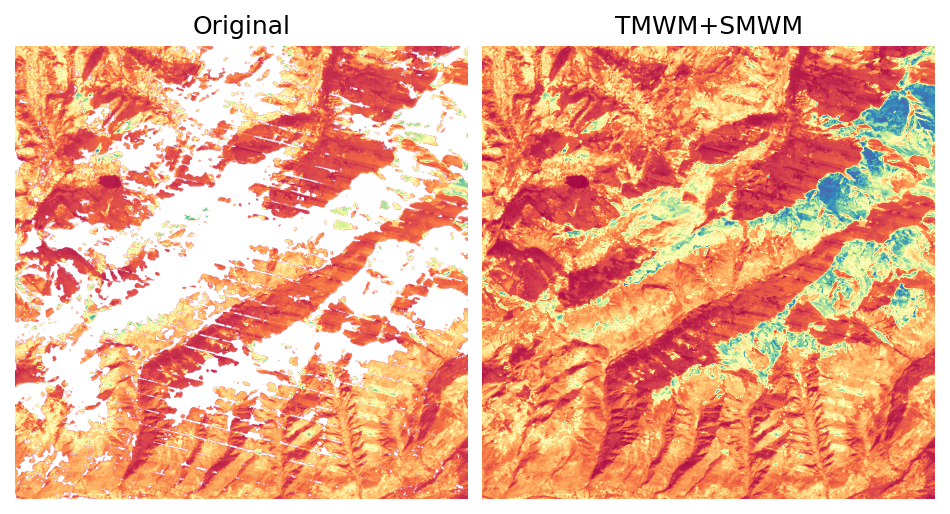

In [15]:
from eumap import plotter

i = 51
img_gaps = fn_rasters[i]
img_gapfilled_tmwm_smwm = fn_rasters_tmwm_smwm[i*2]

print(f'Image: {img_gaps}')
plotter.plot_rasters(
    img_gaps,
    img_gapfilled_tmwm_smwm,
    cmaps='Spectral',
    figsize=8,
    titles=['Original', 'TMWM+SMWM'],
)